# 06 - Comparison of Best Performers

This section is more of a curiosity section that summarises some of the things that we have seen (as many of these comparisons have been done for NAG already in previous sections). We look at the individual best performing learning rate for each optimiser. However, we do acknoweldge that the choice of 'best' is somewhat loose here and was mostly based on the final confusion matrices for each optimiser and its learning rates. Several steps during training from parameter choices all the way to early stopping epochs could have been added, the choice of dropout for a dataset of our size and imbalance is also not necessarily correct or incorrect, but we are satisfied that we have at least offered fair comparison given a somewhat generalisable setup for a particularly imbalanced dataset.

## Import Modules

In [35]:
import time
import json

import random as python_random
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.metrics import TruePositives
from tensorflow.keras.metrics import KLDivergence

from mlxtend.plotting import plot_confusion_matrix

#for reproducibility, we set random seeds here
#Jupyter can sometimes assign seed value only in the cell that the random seed is called
#you can change this rseed value so the entire notebook changes seed values
rseed = 42

np.random.seed(rseed)
python_random.seed(rseed)
tf.random.set_seed(rseed)

## Load Data

We only need to load `X_test` and `y_test_multi` as we are not performing any training and instead loading all our models

In [36]:
#load the dataframes created in the Data.ipynb section
X_test = pd.read_csv('..\data\X_test.csv')
y_test_multi = pd.read_csv('..\data\y_test_multi.csv')

In [37]:
#turn string labels into float categories, categs is list of categories
# y_train_multi, categs = pd.factorize(y_train_multi.connection_category)
# y_val_multi, categs = pd.factorize(y_val_multi.connection_category)
y_test_multi, categs = pd.factorize(y_test_multi.connection_category)
#turn float categories into tf.keras matrix categories of dimension length(categs)
#e.g. 'normal' = [1,0,0,0,0]
# y_train_multi = to_categorical(y_train_multi, num_classes = len(categs))
# y_val_multi = to_categorical(y_val_multi, num_classes = len(categs))
y_test_multi = to_categorical(y_test_multi, num_classes = len(categs))

## Load Models and Histories

We make a list of tuples corresponding to each optimiser and the number of the best performing model saved in our `saved_models` and `saved_hists` files.

In [38]:
opts = [('sgd','1'), 
        ('nag','1'),
        ('sgd_mom','1'),
        ('adam','3')]

In [46]:
#load for the opts above
for (opt,num) in opts:
    locals()['{}_model'.format(opt)] = tf.keras.models.load_model('saved_models/{}_categ_model_{}'.format(opt,num))
    locals()['{}_hist'.format(opt)] = json.load(open('saved_hists/{}_categ_history_{}'.format(opt,num)))

## Plotting and Assessing Performance

We plot the best performing optimisers (only for the categorical case as it was more interesting), to see if we can make any more meaningful comparisons.

**Categorical Cross Entropy:**<br>
We start as always by examining the loss values for our models.

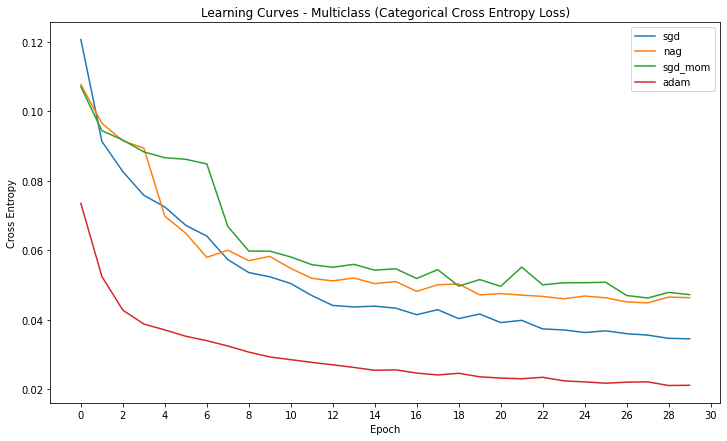

In [47]:
fig = plt.figure(figsize=(12,7))

plt.title('Learning Curves - Multiclass (Categorical Cross Entropy Loss)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

for opt in ['sgd','nag','sgd_mom','adam']:
    plt.plot(locals()['{}_hist'.format(opt)]['val_loss'],
            label = opt)

plt.legend()
plt.show()

This graph is admittedly somewhat deceptive; some of the things that we saw previously (such as how closely NAAG and SGD_MOM) were suddenly seem more different here. This still leaves the chance that there is indeed some difference, but this difference is amplified visually because of how small the loss values are on the y-axis. This is to be expected, however, since these are the best perfoemers and so the loss values were always going to be relatively small.

There are a few points to be made here, though. Firstly, we see ADAM emerging as the lowest loss attainer consistently, which we expected. Secondly, we notice that SGD with no momentum seems to be attaining lower losses than NAG and SGD with momentum. Thirdly, NAG and SGD_MOM follow one another fairly closely though there are some spikes separating them at particular epochs.

The second point may seem contradictory to what we saw in the previous sections, but there we did explicitly compare performance for the lower valued learning rates where we saw NAG perform better than SGD with no momentum. We did not do this for best performers as the values seemed very close to one another, and they indeed are here, but we can see SGD attaining lower loss, though not necessarily better performance, which we look at soon,

**Cohen-Kappa Score:**<br>
We now look at Cohen-Kappa and skip categorical accuracy for brevity, asthey both seemed very similar to one another in all previous sections.

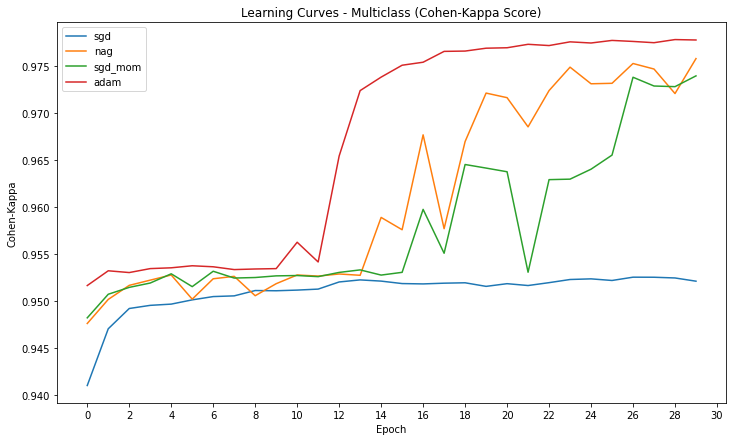

In [48]:
fig = plt.figure(figsize=(12,7))

plt.title('Learning Curves - Multiclass (Cohen-Kappa Score)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,52,2))
plt.ylabel('Cohen-Kappa')

for opt in ['sgd','nag','sgd_mom','adam']:
    plt.plot(locals()['{}_hist'.format(opt)]['val_cohen_kappa'],
            label = opt)

plt.legend()
plt.show()

We see standard SGD perform worse than the other optimisers as expected. It seems that the optimiser becomes better at optimising loss function via assigning with more certainty, without becoming better at assigning overall classes, as discussed previously. NAG and SGD with momentum perform very similarly, with NAG performing slightly better (we saw this comparison in the previous section). ADAM performs better than others in terms of Cohen-Kappa score.

**Confusion Matrices**<br>
For slightly more interpretability, we now look at confusion matrices once more.

In [44]:
tf.random.set_seed(rseed)
#predict for each optimiser
for opt in ['sgd','nag','sgd_mom','adam']:
    locals()['{}_pred'.format(opt)] = locals()['{}_model'.format(opt)].predict(X_test)

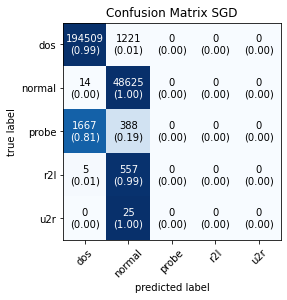

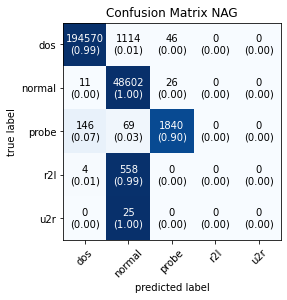

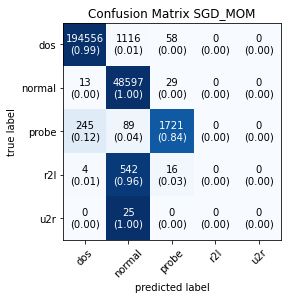

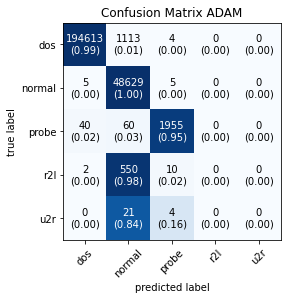

In [45]:
for opt in ['sgd','nag','sgd_mom','adam']:
    prediction = locals()['{}_pred'.format(opt)]
    locals()['{}_cmat'.format(opt)] = confusion_matrix(tf.argmax(y_test_multi,axis=1),tf.argmax(prediction,axis=1))
  
    
    plot_confusion_matrix(
        conf_mat = locals()['{}_cmat'.format(opt)],
        show_normed = True,
        class_names = categs
    )
    plt.title('Confusion Matrix {}'.format(opt.upper()))

The confusion matrices draw the same image that was given to us by the Cohen-Kappa Score: ADAM performs best followed by NAG, SGD with momentum, and SGD without momentum performs the worst out of our optimisers.

The main difference comes from the slight improvement in picking out 'probe' attacks, yet none of the models pick up 'r2l' or 'u2r'. It would have been interesting to explore if running for more epochs for example would've changed this or if we would have seen the same behaviour that we saw for the ADAM optimiser with a learning rate of 0.1 in Section 05.3 where the model took a dramatic turn and predicted only one class. Unfortunately, confusion matrices are not a singular value or score that is easy to compare via plots and Cohen-Kappa has its limitations for our heavily imbalanced scenario. Otherwise, given a more appropriate metric and loss function, it would have been very interesting to plot results across more epochs, or to plot confusion matrices side by side at specific epochs to see how the models' behaviour changed. 

In an ideal world, it would have been great to see interactive confusion matrices heatmaps evolve with an increase of epochs for a much larger number of epochs to gain some visual understanding and interpratibility of what the models were doing, though obviously we did not even attempt to do this as this is largely out of scope.